In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

Data for this notebook has been pulled and used from the NYT GitHub repo that is updated daily <b>[here](https://github.com/nytimes/covid-19-data)</b>

# County-level Exploration - Buncombe & Philadelphia

In [2]:
filepath = '/Users/sinasinai/git/coronavirus/covid-19-data/us-counties.csv'
df = pd.read_csv(filepath)

In [3]:
df['date'] = pd.to_datetime(df.date)
df = df.set_index('date')

In [4]:
buncombe = df.loc[(df.county == 'Buncombe') & (df.state == 'North Carolina')].copy()
philly = df.loc[(df.county == 'Philadelphia') & (df.state == 'Pennsylvania')].copy()

In [5]:
buncombe['day_lag_cases'] = buncombe.shift(periods=1).cases
buncombe['daily_new_cases'] = buncombe.cases - buncombe.day_lag_cases
philly['day_lag_cases'] = philly.shift(periods=1).cases
philly['daily_new_cases'] = philly.cases - philly.day_lag_cases
buncombe['daily_avg_7d'] = buncombe.daily_new_cases.rolling(7).mean()
philly['daily_avg_7d'] = philly.daily_new_cases.rolling(7).mean()

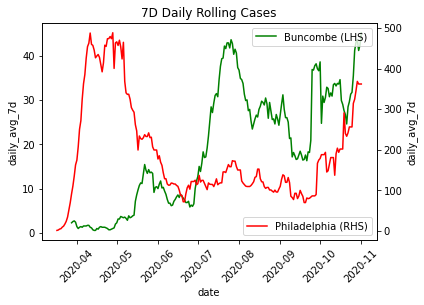

In [6]:
fig = sns.lineplot(x=buncombe.index,y=buncombe.daily_avg_7d,label='Buncombe (LHS)',color='Green')
plt.xticks(rotation=45)
plt.legend(loc='upper right')

fig2 = fig.twinx()
sns.lineplot(x=philly.index,y=philly.daily_avg_7d,ax=fig2,label='Philadelphia (RHS)',color='Red')
plt.legend(loc='lower right')

fig.set_title('7D Daily Rolling Cases')


plt.show()

# National Cases

In [7]:
us = pd.read_csv('us.csv')

In [8]:
us['date'] = pd.to_datetime(us.date)
us = us.set_index('date')

In [9]:
us['daily_lag_cases'] = us.shift(periods=1).cases
us['daily_new_cases'] = us.cases - us.daily_lag_cases

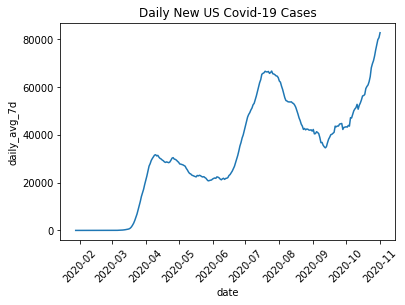

In [10]:
us['daily_avg_7d'] = us.daily_new_cases.rolling(7).mean()
fig = sns.lineplot(x=us.index,y=us.daily_avg_7d)
fig.set_title('Daily New US Covid-19 Cases')
plt.xticks(rotation=45)
plt.show()

In [11]:
us['lag_daily_new_cases'] = us.shift(periods=1).daily_new_cases
us['second_diff_new_cases'] = us.daily_new_cases - us.lag_daily_new_cases

In [12]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

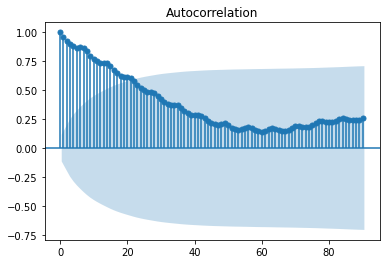

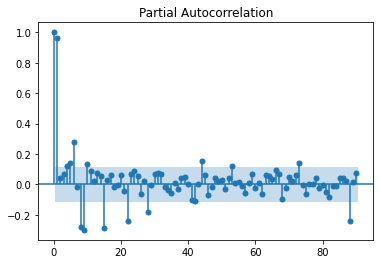

In [13]:
plot_acf(us.daily_new_cases.to_numpy(),missing="drop",lags=90,fft=False)
plot_pacf(us.daily_new_cases.dropna().to_numpy(),lags=90)
plt.show()

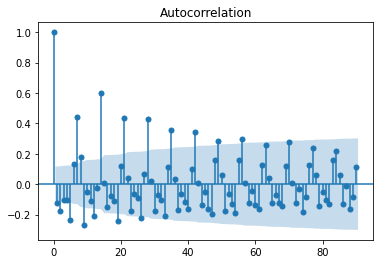

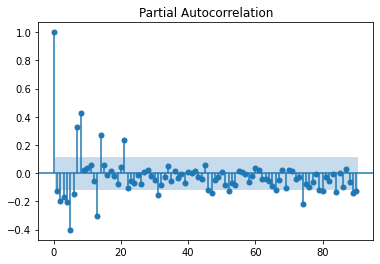

In [14]:
plot_acf(us.second_diff_new_cases.to_numpy(),missing="drop",lags=90,fft=False)
plot_pacf(us.second_diff_new_cases.dropna().to_numpy(),lags=90)
plt.show()

# Forecasting - Seasonal ARIMA - Daily

Following this <b>[tutorial](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b) </b> -- I've omitted a lot of the grid searches

In [19]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA as arima
import statsmodels.api as sm
import itertools

In [27]:
p = range(21,22)
d = range(1,2)
q = range(0,1)
pdq = list(itertools.product(p, d, q))

ps = range(7,8)
ds = range(0,1)
qs = range(0,1)
season = range(91,92)
seasonal_pdq = list(itertools.product(ps, ds, qs, season))

Fiddled with these values for a long time, takes a while to train

In [28]:
seasonal_grid = {}
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(us.daily_new_cases,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print(f"Param combo {param}: {param_seasonal}: {results.aic}")
            seasonal_grid = seasonal_grid[str(param) + str(seasonal_pdq)] = results.aic
        
        except:
            continue

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Param combo (21, 1, 0): (7, 0, 0, 91): 58.0


In [31]:
results.summary()

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:3051: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  warnings.warn('Later subset of data for variable %d'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                     daily_new_cases   No. Observations:                  286
Model:             SARIMAX(21, 1, 0)x(7, 0, 0, 91)   Log Likelihood                   0.000
Date:                             Mon, 02 Nov 2020   AIC                             58.000
Time:                                     22:09:14   BIC                                nan
Sample:                                 01-21-2020   HQIC                               nan
                                      - 11-01-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4581         -0        inf      0.000      -0.458      -0.458
ar.L2         -0.1591         -0        inf      0.000      -0.159      -0.159
ar.L3         -0.1145         -0        inf      0.000      -0.114      -0.114
ar.L4         -0.0921         -0        inf      0.000      -0.092      -0.092
ar.L5          0.0649         -0       -inf      0.000       0.065       0.065
ar.L6          0.1715         -0       -inf      0.000       0.171       0.171
ar.L7          0.2858         -0       -inf      0.000       0.286       0.286
ar.L8          0.3852         -0       -inf      0.000       0.385       0.385
ar.L9          0.0991         -0       -inf      0.000       0.099       0.099
ar.L10         0.0854         -0       -inf      0.000       0.085       0.085
ar.L11         0.0084         -0       -inf      0.000       0.008       0.008
ar.L12        -0.1279         -0        inf      0.000      -0.128      -0.128
ar.L13        -0.2236         -0        inf      0.000      -0.224      -0.224
ar.L14         0.3163         -0       -inf      0.000       0.316       0.316
ar.L15         0.0712         -0       -inf      0.000       0.071       0.071
ar.L16        -0.0616         -0        inf      0.000      -0.062      -0.062
ar.L17         0.0261         -0       -inf      0.000       0.026       0.026
ar.L18         0.0231         -0       -inf      0.000       0.023       0.023
ar.L19        -0.0834         -0        inf      0.000      -0.083      -0.083
ar.L20         0.0555         -0       -inf      0.000       0.055       0.055
ar.L21         0.2777         -0       -inf      0.000       0.278       0.278
ar.S.L91            0         -0        nan        nan           0           0
ar.S.L182           0         -0        nan        nan           0           0
ar.S.L273           0         -0        nan        nan           0           0
ar.S.L364           0         -0        nan        nan           0           0
ar.S.L455           0         -0        nan        nan           0           0
ar.S.L546           0         -0        nan        nan           0           0
ar.S.L637           0         -0        nan        nan           0           0
sigma2      1.184e+07         -0       -inf      0.000    1.18e+07    1.18e+07
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-st

Standard errors of zero probably indicate overfitting - will plot just to see what it looks like

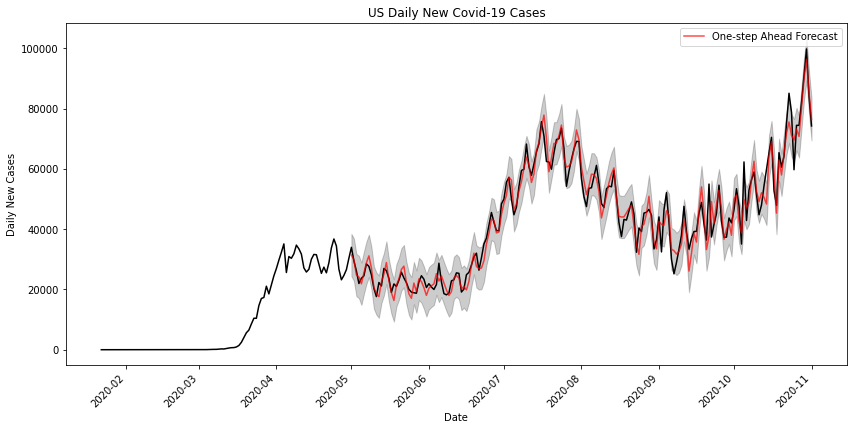

In [32]:
pred = results.get_prediction(start=pd.to_datetime('2020-05-01'))
pred_ci = pred.conf_int()

fig = sns.lineplot(x=us.index,y=us.daily_new_cases,color='black')
fig.set_title('US Daily New Covid-19 Cases')

pred.predicted_mean.plot(ax=fig, label='One-step Ahead Forecast', alpha=.7, figsize=(14, 7),color='red')
fig.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.xticks(rotation=45)
fig.set_xlabel('Date')
fig.set_ylabel('Daily New Cases')
plt.legend()
plt.show()

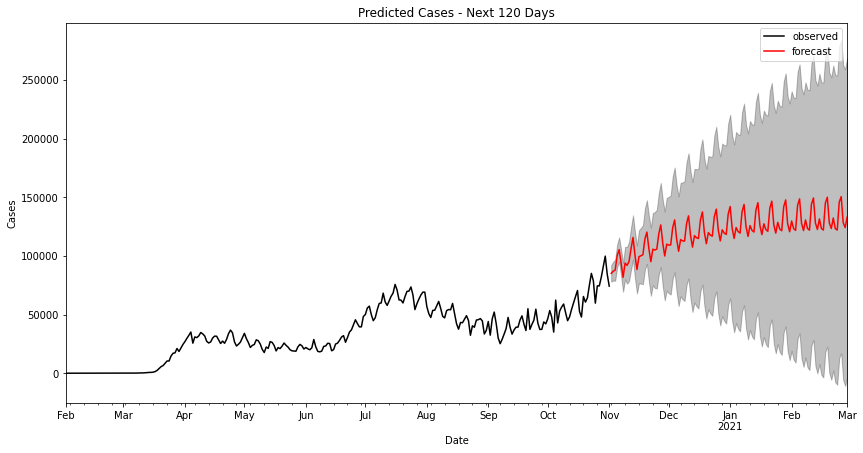

In [33]:
pred_uc = results.get_forecast(steps=120)
pred_ci = pred_uc.conf_int()
ax = us[pd.to_datetime('2020-02-01'):].daily_new_cases.plot(label='observed', figsize=(14, 7),color='black')
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Cases')
ax.set_title('Predicted Cases - Next 120 Days')
plt.legend()
plt.show()

Lol not great

# Weekly Seasonal ARIMA - Auto-ARIMA

In [63]:
import pmdarima as pm

weekly = us.groupby(us.index.isocalendar().week).sum()
#['daily_new_cases']

In [37]:
weekly_cases = us.groupby(us.index.isocalendar().week).sum()['daily_new_cases']

In [85]:
stepwise_fit = pm.auto_arima(weekly_cases, start_p=1, start_q=1,
                             max_p=4, max_d=2, max_q=4, m=15,
                             start_P=0, max_P=4, max_D=2, seasonal=True,trace=True,
                             out_of_sample_size=4, max_Q= 4,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True) 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[15] intercept   : AIC=620.087, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[15] intercept   : AIC=656.526, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[15] intercept   : AIC=619.343, Time=0.18 sec
 ARIMA(0,0,1)(0,1,1)[15] intercept   : AIC=642.624, Time=0.13 sec
 ARIMA(0,0,0)(0,1,0)[15]             : AIC=707.046, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[15] intercept   : AIC=619.836, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[15] intercept   : AIC=620.828, Time=0.42 sec
 ARIMA(1,0,0)(1,1,1)[15] intercept   : AIC=621.217, Time=0.21 sec
 ARIMA(1,0,0)(0,1,1)[15] intercept   : AIC=619.852, Time=0.12 sec
 ARIMA(1,0,0)(2,1,1)[15] intercept   : AIC=623.285, Time=0.73 sec
 ARIMA(0,0,0)(1,1,0)[15] intercept   : AIC=653.277, Time=0.11 sec
 ARIMA(2,0,0)(1,1,0)[15] intercept   : AIC=616.891, Time=0.23 sec
 ARIMA(2,0,0)(0,1,0)[15] intercept   : AIC=618.505, Time=0.05 sec
 ARIMA(2,0,0)(2,1,0)[15] intercept   : AIC=618.103, Time=0.55 sec
 ARIMA(2,0,0)(1,1,1)[15] intercep

In [86]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   41
Model:             SARIMAX(2, 0, 1)x(1, 1, [], 15)   Log Likelihood                -301.348
Date:                             Mon, 02 Nov 2020   AIC                            614.697
Time:                                     22:49:07   BIC                            622.245
Sample:                                          0   HQIC                           616.870
                                              - 41                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.243e+04   1.58e+04      2.679      0.007    1.14e+04    7.35e+04
ar.L1          1.7694      0.193      9.146      0.000       1.390       2.149
ar.L2         -0.9376      0.177     -5.303      0.000      -1.284      -0.591
ma.L1         -0.7179      0.338     -2.121      0.034      -1.381      -0.055
ar.S.L15      -0.5539      0.290     -1.909      0.056      -1.123       0.015
sigma2      1.071e+09      0.015   6.94e+10      0.000    1.07e+09    1.07e+09
===================================================================================
Ljung-Box (Q):                       23.70   Jarque-Bera (JB):                 0.98
Prob(Q):                              0.54   Prob(JB):                         0.61
Heteroskedasticity (H):               1.17   Skew:                             0.17
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.91e+28. Standard errors may be unstable.
"""

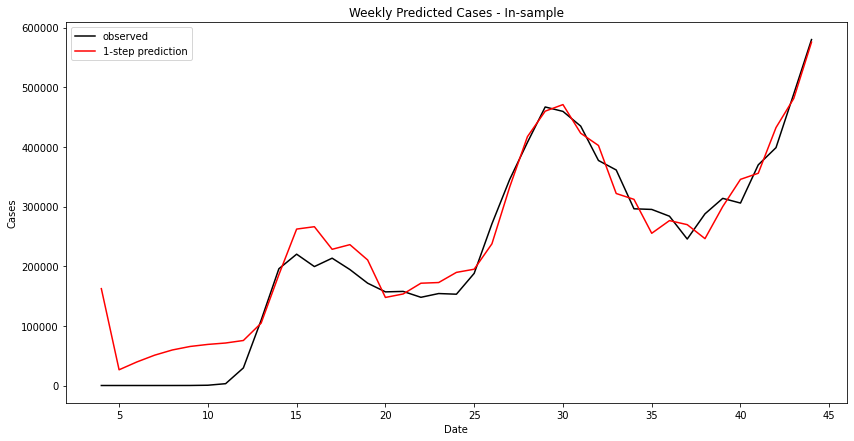

In [91]:
in_sample = stepwise_fit.predict_in_sample(return_conf_int=True)
pred = pd.DataFrame(in_sample[0],index=weekly_cases.index,columns=['1-step prediction'])
pred_ci = pd.DataFrame(in_sample[1],index=weekly_cases.index)

ax = weekly_cases.plot(label='observed', figsize=(14, 7),color='black')
pd.DataFrame(pred,index=weekly_cases.index).plot(ax=ax, label='forecast',color='red')

ax.set_xlabel('Date')
ax.set_ylabel('Cases')
ax.set_title('Weekly Predicted Cases - In-sample')
plt.legend()
plt.show()

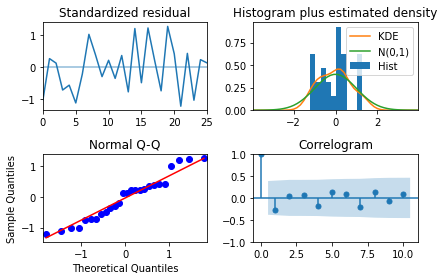

In [92]:
fig = stepwise_fit.plot_diagnostics()
plt.tight_layout()
plt.show()

In [93]:
steps= 26
future_index = [c + max(weekly_cases.index) for c in range(1,steps+1)]
pred_future = pd.DataFrame(stepwise_fit.predict(n_periods=steps,return_conf_int=True)[0],index=future_index)
pred_future.columns =['predicted']

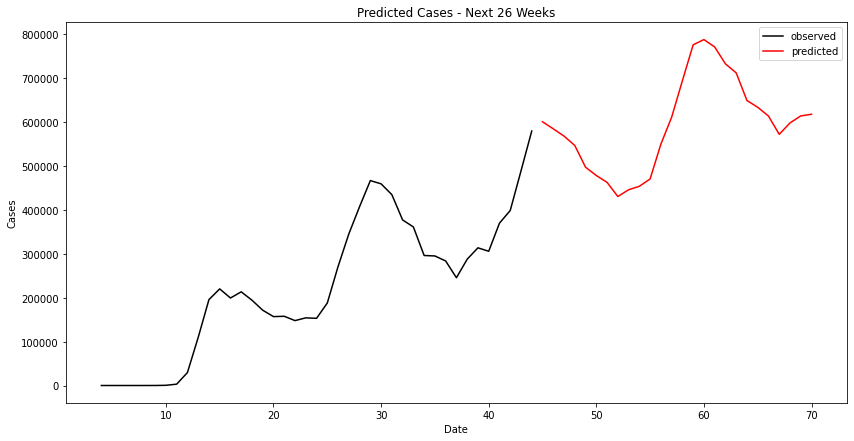

In [94]:
ax = weekly_cases.plot(label='observed', figsize=(14, 7),color='black')
pred_future.plot(ax=ax, label='forecast',color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Cases')
ax.set_title(f"Predicted Cases - Next {steps} Weeks")
plt.legend()
plt.show()

Much better -- weekly "seasonality" is smoothed out at the weekly level